In [102]:
import pickle
import numpy as np
import pandas as pd

In [103]:
class Model:
    name = ''
    rmse = 0.0
    model = ''
    final_model = ''

## Load the models

In [104]:
labels = pickle.load(open('models/labels.pkl', 'rb'))

baseline = Model()
baseline.name = 'baseline'
baseline.model = pickle.load(open('models/baseline.pkl', 'rb'))
baseline.final_model = pickle.load(open('final_models/baseline_final.pkl', 'rb'))

bsknn = Model()
bsknn.name = 'bsknn'
bsknn.model = pickle.load(open('models/bsknn.pkl', 'rb'))
bsknn.final_model = pickle.load(open('final_models/bsknn_final.pkl', 'rb'))

so = Model()
so.name = 'so'
so.model = pickle.load(open('models/so.pkl', 'rb'))
so.final_model = pickle.load(open('final_models/so_final.pkl', 'rb'))

svd = Model()
svd.name = 'svd'
svd.model = pickle.load(open('models/svd.pkl', 'rb'))
svd.final_model = pickle.load(open('final_models/svd_final.pkl', 'rb'))

als = Model()
als.name = 'als'
als.model = pickle.load(open('models/als.pkl', 'rb'))
als.final_model = pickle.load(open('final_models/als_final.pkl', 'rb'))

sgd = Model()
sgd.name = 'sgd'
sgd.model = pickle.load(open('models/sgd.pkl', 'rb'))
sgd.final_model = pickle.load(open('final_models/sgd_final.pkl', 'rb'))

In [105]:
trainset = pickle.load(open('models/trainset.pkl', 'rb'))
testset = pickle.load(open('models/testset.pkl', 'rb'))

In [107]:
globalmean = Model()
globalmean.name = 'globalmean'
globalmean.model = pickle.load(open('models/globalmean.pkl', 'rb'))
globalmean.final_model = pickle.load(open('final_models/globalmean_final.pkl', 'rb'))

usermean = Model()
usermean.name = 'usermean'
usermean.model = pickle.load(open('models/usermean.pkl', 'rb'))
usermean.final_model = pickle.load(open('final_models/usermean_final.pkl', 'rb'))

itemmean = Model()
itemmean.name = 'itemmean'
itemmean.model = pickle.load(open('models/itemmean.pkl', 'rb'))
itemmean.final_model = pickle.load(open('final_models/itemmean_final.pkl', 'rb'))

In [108]:
itemmean.final_model

array([3.75773196, 3.54      , 4.23021583, ..., 3.26315789, 3.32432432,
       4.08196721])

In [110]:
#so.model[0:5]
baseline.model[0:5]

array([4.12968289, 2.74688911, 4.57559919, 3.33154962, 3.51639563])

#### Compute RMSE for each model 

The ranking of the models will be done from the lower RMSE to the higher

In [111]:
def calculate_rmse(real_labels, predictions):
    """Calculate RMSE."""
    return np.linalg.norm(real_labels - predictions) / np.sqrt(len(real_labels))

In [112]:
models = [globalmean, usermean, itemmean, baseline, bsknn, so, svd, als, sgd]

In [113]:
for m in models:
    m.rmse = calculate_rmse(labels, m.model)

In [114]:
import operator
sorted_models = sorted(models, key=operator.attrgetter('rmse'))

In [115]:
for m in sorted_models:
    print('Model %s : %s' % (m.name,m.rmse))

Model als : 0.9847793154728643
Model bsknn : 0.9856320314606993
Model baseline : 0.99682477632627
Model so : 0.9975163718778954
Model svd : 0.9985292578511148
Model sgd : 1.0225406549501423
Model usermean : 1.0287576733249626
Model itemmean : 1.092430990841759
Model globalmean : 1.1173583797240298


## Find the number of model to put in blending

In [116]:
from sklearn.linear_model import Ridge

rmse_evolution = []

for i in range(len(sorted_models)):
    prediction = []
    k_models = sorted_models[0:i+1]
    
    for m_id, m in enumerate(k_models):
        if m_id == 0:
            prediction = m.model
        else:
            prediction = np.vstack((prediction,m.model))
        
    prediction = pd.DataFrame(prediction)
    
    if i != 0:
        prediction = np.transpose(prediction)
    
    #print(prediction.shape)
    
    # Blending
    linreg = Ridge(alpha=0.1, fit_intercept=False)
    linreg.fit(prediction, labels)
    #print(linreg.coef_) # print weight for each model
    
    rmse = calculate_rmse(labels, prediction.dot(linreg.coef_))
    print('With %s model(s) : %s' % (i+1,rmse))
    rmse_evolution.append(rmse)
    

With 1 model(s) : 0.9784070018378641
With 2 model(s) : 0.9777706647890264
With 3 model(s) : 0.9768877348383052
With 4 model(s) : 0.9767416302147582
With 5 model(s) : 0.9767289333715918
With 6 model(s) : 0.9766848503525928
With 7 model(s) : 0.9763589283189532
With 8 model(s) : 0.9763393117928193
With 9 model(s) : 0.9761475400155901


In [117]:
rmse_evolution

[0.9784070018378641,
 0.9777706647890264,
 0.9768877348383052,
 0.9767416302147582,
 0.9767289333715918,
 0.9766848503525928,
 0.9763589283189532,
 0.9763393117928193,
 0.9761475400155901]

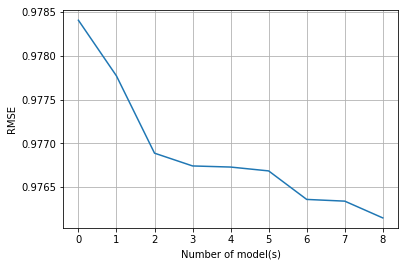

In [133]:
import matplotlib.pyplot as plt
plt.plot(range(len(rmse_evolution)),rmse_evolution)
plt.xlabel('Number of model(s)')
plt.ylabel('RMSE')

plt.grid(True)
plt.savefig("test.png", bbox_inches='tight')

plt.show()

In [119]:
best_nbrmodel = 8

## Final Blending

In [134]:
from sklearn.linear_model import Ridge

prediction = []
k_models = sorted_models[0:best_nbrmodel+1]
    
for m_id, m in enumerate(k_models):
    if m_id == 0:
        prediction = m.model
    else:
        prediction = np.vstack((prediction,m.model))
        
prediction = pd.DataFrame(prediction)
    
if i != 0:
    prediction = np.transpose(prediction)
    
#print(prediction.shape)
    
# Blending
linreg = Ridge(alpha=0.1, fit_intercept=False)
linreg.fit(prediction, labels)
print(linreg.coef_) # print weight for each model
    
rmse = calculate_rmse(labels, prediction.dot(linreg.coef_))

[ 1.04032424  0.2961305  -0.67350879  0.11267265  0.31748628  0.03738606
 -0.09065254 -0.20815998  0.19939457]


#### Final prediction

In [138]:
final_result = []

for m_id, m in enumerate(sorted_models):
    if m_id == 0:
        final_result = linreg.coef_[m_id] * m.final_model
    else:
        final_result = final_result + linreg.coef_[m_id] * m.final_model

print(final_result.shape)

(1176952,)


In [ ]:
#result = pred_SGD * linreg.coef_[0] + pred_ALS * linreg.coef_[1] + pred_globalmean * linreg.coef_[2] + pred_usermean * linreg.coef_[3] + pred_itemmean * linreg.coef_[4]

In [140]:
from helper import *
create_submission_from_prediction(final_result, "out-test-9models.csv")